In [1]:
import numpy as np # library for data structures, vectors, matrices and mathematical functions
import matplotlib.pyplot as plt                   # library for plotting and visual representation
import matplotlib.transforms as transform                   # library for plotting and visual representation
from matplotlib import rcParams                   # module handling generic plot parameters
from matplotlib.ticker import (FormatStrFormatter)# module for figure axis formatting
import pandas as pd                               # data administration, here used for data import
from scipy.optimize import curve_fit              # fitting algorithm from the scipy package
from IPython.display import display as dy, Markdown as md, Latex as Lx, Image as Im, HTML as hm # displaying LaTeX code in code cells
import os
import re
from scipy.signal import find_peaks

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 15,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'figure.figsize': (10,6),
                    })

plt.rcParams['axes.facecolor'] = 'black' 
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['xtick.labelcolor'] = 'white'
plt.rcParams['ytick.labelcolor'] = 'white'
plt.rcParams['legend.labelcolor'] = 'white'
plt.rcParams['grid.color'] = '#707070'
plt.rcParams['axes.titlepad'] = 20
legendfontsize=12

ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = { 'pdf', 'png'}

#  E19e Digital Oscilloscope

Group #13

NG Kuok Fung | #3797903 

Edgar Harutyunyan | #3775171

**Overview of Tasks**

**1. Basics**

   **1a.** Measure a sine signal with a fixed range of $\pm 1~V$, using a resolution of 8 bit, 12 bit and 14 bit. Determine the size of the discretization steps from the curves and compare with the nominal resolution.

   **1b.** Measure the spectrum of a sine signal with a resolution of 14 bit using a Blackman window. Save the spectrum both with $dbV$ units and on a linear scale. From the spectrum with linear scale, calculate the spectrum in $dbV$ units and compare to the spectrum stored directly with a $dbV$ scale.

**2. Aliasing**

   **2a.** Choose oscilloscope parameters such that you have a spectrum with maximum frequency of $100~kHz$, Blackman window and 16384 points. Measure the spectra of sine signals with frequencies of $10 ~kHz$, $90~ kHz$, $110 ~kHz$, $190~ kHz$, $210~ kHz$ and $290~ kHz$. 
   
   What do you observe? From your observation, derive an equation for the apparent frequency as a function of the real generator frequency.

   **2b.** Choose parameters such that you have a spectrum with maximum frequency of $100 ~kHz$, Blackman window and 16384 points. Measure the spectra of square signals with frequencies of $5 ~kHz$ and $7~ kHz$.
   
   Why do the spectra look so different? Measure the peak heights of the 10 peaks in the $5 ~kHz$ spectrum and of the leading 20 peaks in the $7~kHz$ spectrum. Plot the peak heights vs. frequency and compare with the theoretical expression. What do you observe? Explain.


**3. Windowing**

   **3a.** Measure the spectra of a square signal using a rectangular, a Hann and a flat-top window. Use the following parameters: time constant of $1~ ms$, $20~ kS$, 16384 points in the spectrum and a frequency of $1 ~kHz$.
   
   Compare the spectra. What do you observe? Which windowing method has the worst amplitude resolution? Which windowing method has the worst frequency resolution?
   
   **3b.** Measure the spectra of a sine signal using a rectangular, a triangular and a flat-top window. Use parameters such that you can see a distinct Fraunhofer pattern in case of the rectangular window. Compare the theoretical expressions for rectangular and triangular windowing quantitatively to the data.


**4. Creating and analyzing a WAV file**

Create a WAV file from an arbitrary function. Feed this sound into the oscilloscope and do a spectral
analysis.

In [2]:
# GLOBALS
data_dir='./data/'

def fit_and_plot(df, x_col, y_col, xlabel, ylabel, title, fit_func):
    plt.scatter(df[x_col], df[y_col], color='#ADD8E6',marker='x', label=r'Data')
    #plt.scatter(df[x_col], df[y_col], color=color,marker='x', label=f'{ylabel[:-4]} vs {xlabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    # Perform non-linear regression using curve_fit
    x = df[x_col].values
    y = df[y_col].values
    params, cov_mat = curve_fit(fit_func, x, y)
    
    # Plot the fitted curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, *params)
    plt.plot(x_fit, y_fit, color='red', label='Fitted Curve')
    plt.legend()
    plt.show()
    return [params, cov_mat]

## Task 1

### Task 1a

***Task Definition*** 

Measure a sine signal with a fixed range of $\pm 1~V$, using a resolution of 8 bit, 12 bit and 14 bit. Determine the size of the discretization steps from the curves and compare with the nominal resolution.

***Theoretical basis***

The discretization step is defined as:

$$\Delta V = \frac{V_{max} - V_{min}}{2^{N-1}}$$

where N is the number of bit resolution. 

The interval is divided by the $2^{N-1}$ instead of $2^N$ to account the least significant bit(LSB) of digitalization $^{[3]}$.

***Procedure***

1. Each sine wave is analyzed by taking the difference between each consecutive point and plotting a histogram.

2. The bin corresponding to '0' value was discarded as noise.

3. The expected value of the discretization step is taken as the highest count bin. 

In [3]:
# Data Preprocessing
task_dir = data_dir + 'Task1a/csv/'
res_l = [] # resolution
res_label_l = []
df_l = []

for path in os.listdir(task_dir):
    if os.path.isfile(task_dir+path):
        s = re.findall('.*bit', path)[0] #Find all files with bit ending
        res_label_l.append(s[:-3] + '~bit') #collect labels
        r = int(s[:-3]) #Slice last 3 elements and convert to float
        res_l.append(r) # pF floats
        df = pd.read_csv(task_dir + path, delimiter=';', skiprows=1, dtype=np.float64, decimal=',')
        df.columns = ['Time', 'Voltage'] 
        df_l.append(df)
    
sorted_lists = sorted(zip(res_l, res_label_l, df_l))
res_l, res_label_l, df_l = zip(*sorted_lists)

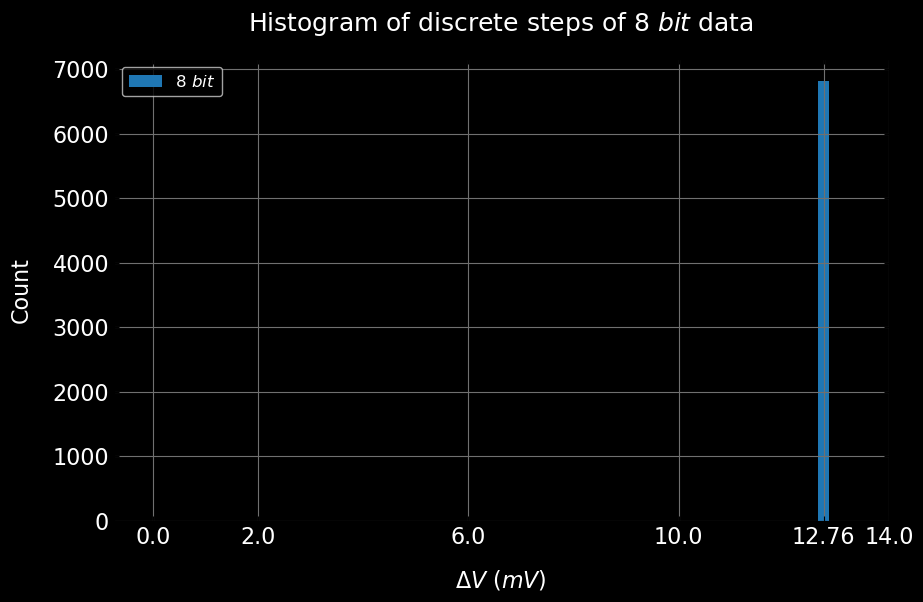

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

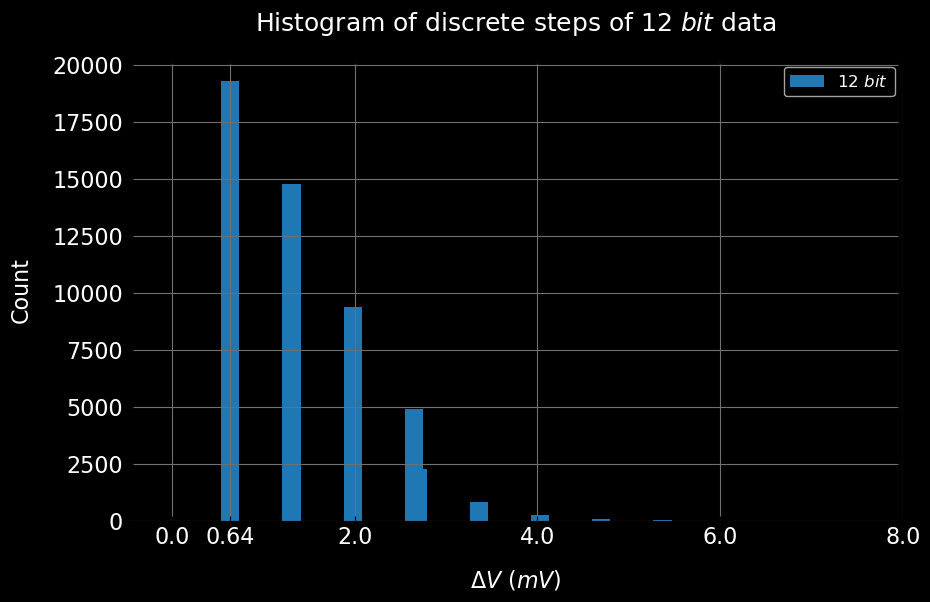

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

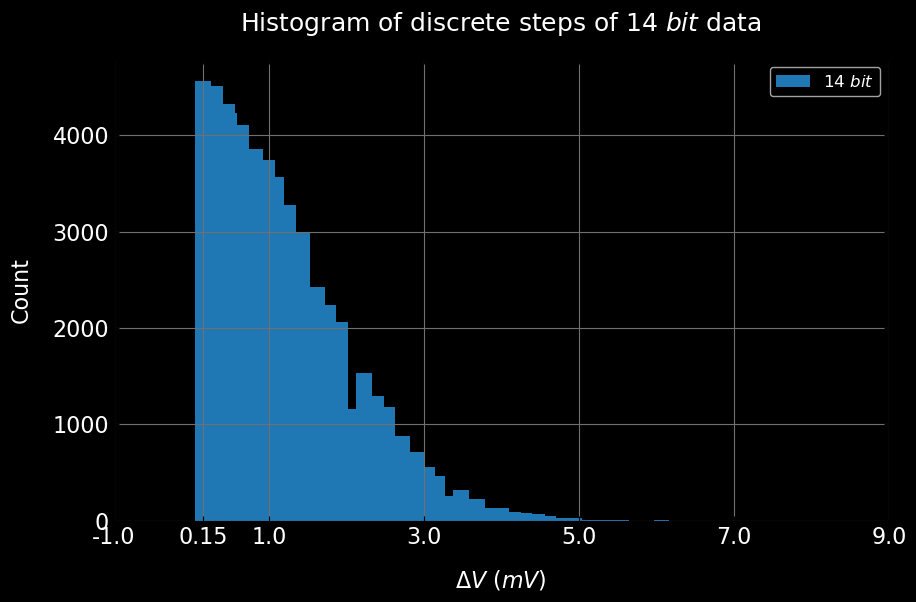

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
for i in range(len(res_l)):
    fig, ax = plt.subplots(1,1)
    ind_min = df_l[i][df_l[i]['Time'] > 2].first_valid_index()
    ind_max = df_l[i][df_l[i]['Time'] > 3].first_valid_index()
    label_s = r'$%s$' % res_label_l[i]
    x = np.array(df_l[i]['Time'])
    y = np.array(df_l[i]['Voltage'])
    diff_v = np.round(np.abs(np.diff(y)),5)
    sss = set(diff_v)
    sss = list(sss)
    sss.sort()
    #print('Number of bins =',len(sss))
    #bins = round((diff_v.max() - diff_v.min()) / bin_width)
    counts, bins = np.histogram(diff_v, density=False, bins=len(sss))
    counts[0] = 0
    ax.bar(1e3*np.array(sss), height=counts, width=0.2,label=label_s)
    ind = np.where(counts == counts[1:].max())[0][0]
    del_V = (np.max(df_l[i]['Voltage']) - np.min(df_l[i]['Voltage']))/ 2**(res_l[i]-1)

    xt = ax.get_xticks()
    if i!=2:
        xt = xt[np.where(xt >= 0)[0]]
    #print(xt)
    mask = np.linspace(0,len(xt)-1,len(xt)//2+1, dtype=int)
    #print(mask)
    xt = xt[mask]
    xt = np.append(xt,sss[ind]*1e3)
    xtl= xt.tolist()
    #xtl[-1]=str(sss[ind]*1e3)
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)
    #plt.xtick(1e3*np.array(sss)[ind])
    #plt.hist(diff_v, bins=bins, density=True, label=label_s)
    #plt.stairs(counts, bins, label=label_s, rwidth=0.002)
    #plt.hist(bins[:-1], bins, weights=counts)
    
    #plt.scatter(x[peaks], y[peaks], marker='x')
    if False:
        #plt.plot(x, y_th*1e3, label=label_s)
        #plt.scatter(x, y*1e3, label=label_s, marker='x')
        #plt.plot(x[ind_min:ind_max], y_th[ind_min:ind_max]*1e3, label=label_s)
        #plt.scatter(x[ind_min:ind_max], y[ind_min:ind_max]*1e3, label=label_s, marker='x')
        plt.scatter(x_filtered[ind_min_filt:ind_max_filt], y_filtered[ind_min_filt:ind_max_filt]*1e3, label=label_s, marker='x')
        #plt.errorbar(x[ind_min:ind_max], y_th[ind_min:ind_max]*1e3, yerr=sigma*1e3, capsize=2, fmt="--x", ecolor = "white")
        #plt.scatter(x, y*1e3, label=label_s, marker='x')
        #plt.errorbar(x, y_th*1e3, yerr=3*sigma*1e3, capsize=3, fmt="--x", ecolor = "white")
    
    ax.set_title(r'Histogram of discrete steps of $%s$ data' % res_label_l[i])
    ax.set_xlabel(r'$\Delta V$ ($mV$)')
    ax.set_ylabel(r'Count')
    #plt.xlabel(r'$U$ ($\mu V$)')
    ax.legend()
    ax.grid(True)
    plt.show(fig)
    dy(Lx(r'$Figure\, 1.%s$: Histogram of differencies of $%s$ resolution sine wave.' % (str(i+1), res_label_l[i])))
    dy(Lx('Theoretical value of discretization:'))
    dy(Lx(r'$$\Delta V_{%s} = %.2f ~mV$$' % (res_label_l[i], del_V*1e3)))
    dy(Lx('Computed value of discretization:'))
    dy(Lx(r'$$\Delta \tilde{V}_{%s} = %.2f ~mV$$' % (res_label_l[i], sss[ind]*1e3)))

### Task 1b

***Task Definition*** 

Measure the spectrum of a sine signal with a resolution of 14 bit using a Blackman window. Save the spectrum both with $dBV$ units and on a linear scale. From the spectrum with linear scale, calculate the spectrum in $dBV$ units and compare to the spectrum stored directly with a $dBV$ scale.

$$L = 20 \log_{10} {\frac{V}{V_0}}$$

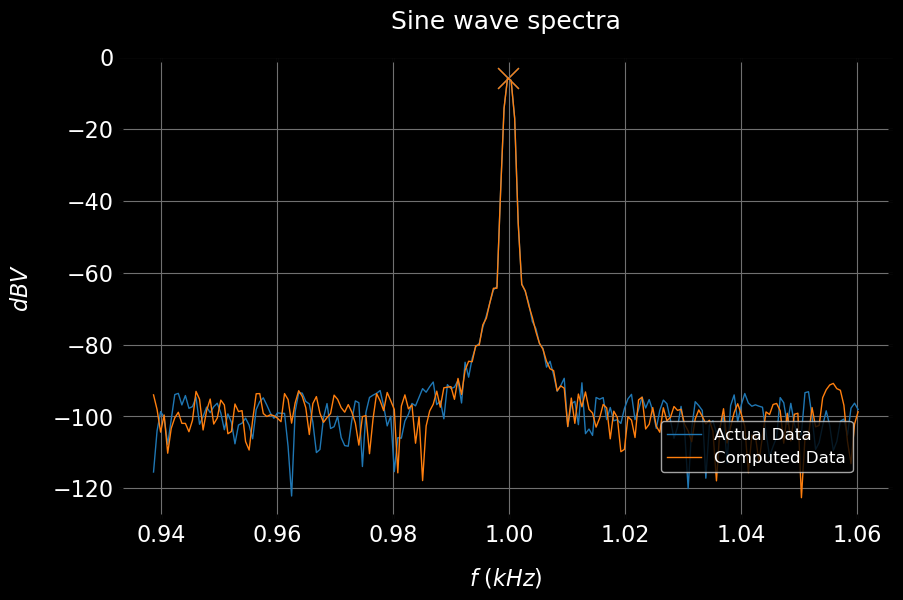

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
# Data Preprocessing
task_dir = data_dir + 'Task1b/csv/'
df_linear = pd.read_csv(task_dir + 'Linear.csv', delimiter=';', skiprows=1, dtype=np.float64, decimal=',')
df_linear.columns = ['Frequency', 'Voltage'] 
df_log = pd.read_csv(task_dir + 'Log.csv', delimiter=';', skiprows=1, dtype=np.float64, decimal=',')
df_log.columns = ['Frequency', 'Voltage']

freq = np.array(df_log['Frequency'])
V_lin = np.array(df_linear['Voltage'])
V_log = np.array(df_log['Voltage'])
max_ind = V_log.argmax()
V_log_th = 20*np.log10(V_lin/1)
max_ind_th = V_log_th.argmax()
plt.plot(freq[max_ind-100:max_ind+100], V_log[max_ind-100:max_ind+100], label='Actual Data')
plt.plot(freq[max_ind_th-100:max_ind_th+100], V_log_th[max_ind_th-100:max_ind_th+100], label='Computed Data')
plt.scatter(freq[max_ind], V_log[max_ind], marker='x')
plt.scatter(freq[max_ind_th], V_log_th[max_ind_th], marker='x')
plt.title(r'Sine wave spectra')
plt.xlabel(r'$f$ ($kHz$)')
plt.ylabel(r'$dBV$')
#plt.xlabel(r'$U$ ($\mu V$)')
plt.legend(loc=(0.7,0.1))
plt.grid(True)
plt.show()
dy(Lx(r'$Figure\, 1.4$: Spectra of sine wave in logarithmic scale.'))
dy(Lx(r'Frequency from computed data: $$\tilde{f} = %.2f ~kHz$$' % freq[max_ind_th]))
dy(Lx(r'Frequency from actual data: $$f = %.2f ~kHz$$' % freq[max_ind]))

## Task 2

### Task 2a

***Task Definition*** 

- Choose oscilloscope parameters such that the frequency spectrum has a maximum frequency of 100 kHz, Blackman window and 16384 points. Measure the spectra of sine signals with frequencies of 10 kHz, 90 kHz, 110 kHz, 190 kHz, 210 kHz and 290 kHz.
<br> 

- What do you observe? From your observation, derive an equation for the apparent frequency as a function of the real generator frequency. 


***Measurements***

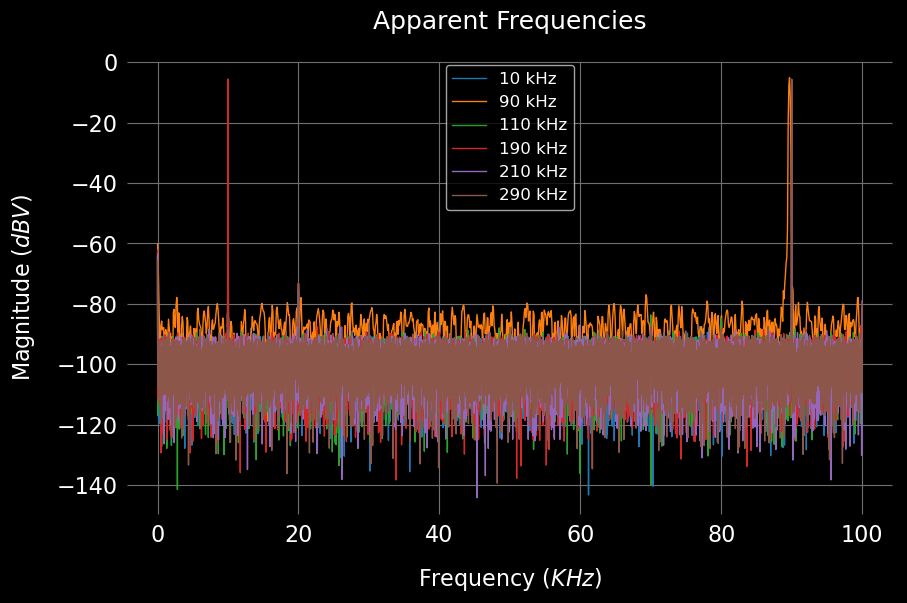

<IPython.core.display.Latex object>

In [6]:
# Data Preprocessing
task_dir = data_dir+'Task2a/csv/'
f_l = [] # Frequency in KHz
df_l = []
a_f_l = []

for path in os.listdir(task_dir):
    s = re.findall('.*KHz', path)[0] #Find all files with KHz ending
    #C_k_str_l.append(s) #Append s to C_k_str_list
    r = int(s[:-3]) #Slice last 2 elements and convert to float #Number
    f_l.append(r) # KHz floats #Number
    df = pd.read_csv(task_dir+path, delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
    df.columns = ['Frequency', 'dbV'] 
    df_l.append(df)
    
for i in range(len(f_l)):
    x = np.array(df_l[i]['Frequency'])
    y = np.array(df_l[i]['dbV'])
    peaks, _ = find_peaks(y, height=-60)
    a_f_l.append(round(x[peaks][0]))
    

sorted_lists = sorted(zip(f_l, a_f_l))
f_l, a_f_l = zip(*sorted_lists)

plt.figure(figsize=(10, 6))

for i, df in enumerate(df_l):
    plt.plot(df['Frequency'], df['dbV'], label=f'{f_l[i]} kHz')

plt.xlabel('Frequency ($KHz$)')
plt.ylabel('Magnitude ($dBV$)')
plt.title('Apparent Frequencies')
plt.legend()
plt.grid(True)
plt.show()
dy(Lx(r'$Figure\, 2.1$: Spectra of sine wave with different frequencies.'))

| # | Generator Freq $f_g$ (kHz) | Apparent Freq $f_p$ (kHz)|
| --- | --- | --- |
| 1 | 10 | 10 |
| 2 | 90 | 90 |
| 3 | 110 | 90 |
| 4 | 190 | 10 |
| 5 | 210 | 10 |
| 6 | 290 | 90 |

***Analysis*** 

1. During the experiment, a sampling freqeuncy of $f_s = 200 ~kHz$ was used. Hence, the Nyquist Frequency is $f_c = 100 ~kHz$
<br>

2. This means that all generated frequencies $f_g > f_c$ are aliased as per Nyquist theorem.
<br>

3. By observation of the measured values of $f_p$ and Nyquist Theorem $^{[2]}$, the equation of the apparent frequency $f_p$ as a function of the real generator frequency $f_g$ is given by: 

$$ f_p = f_g - f_s\cdot NINT\left(\frac{f}{f_s}\right)$$

- $f_p$ : Apparent frequency
- $f_g$ : Real Generator frequency 
- $f_s$ : Sampling Freqeuency
- $NINT\left(\frac{f}{f_s}\right)$ : Nearest Interger Function of $\frac{f}{f_s}$

### Task 2b

***Task Definition*** 

- Choose parameters such that you have a spectrum with maximum frequency of 100 kHz, Blackman window and 16384 points. Measure the spectra of square signals with frequencies of 5 kHz and 7 kHz.
<br>

- Why do the spectra look so different? Measure the peak heights of the 10 peaks in the 5 kHz spectrum and of the leading 20 peaks in the 7 kHz spectrum. Plot the peak heights vs. frequency and compare with the theoretical expression. What do you observe? Explain. 

***Measurements (Square Signal Spectra)*** 

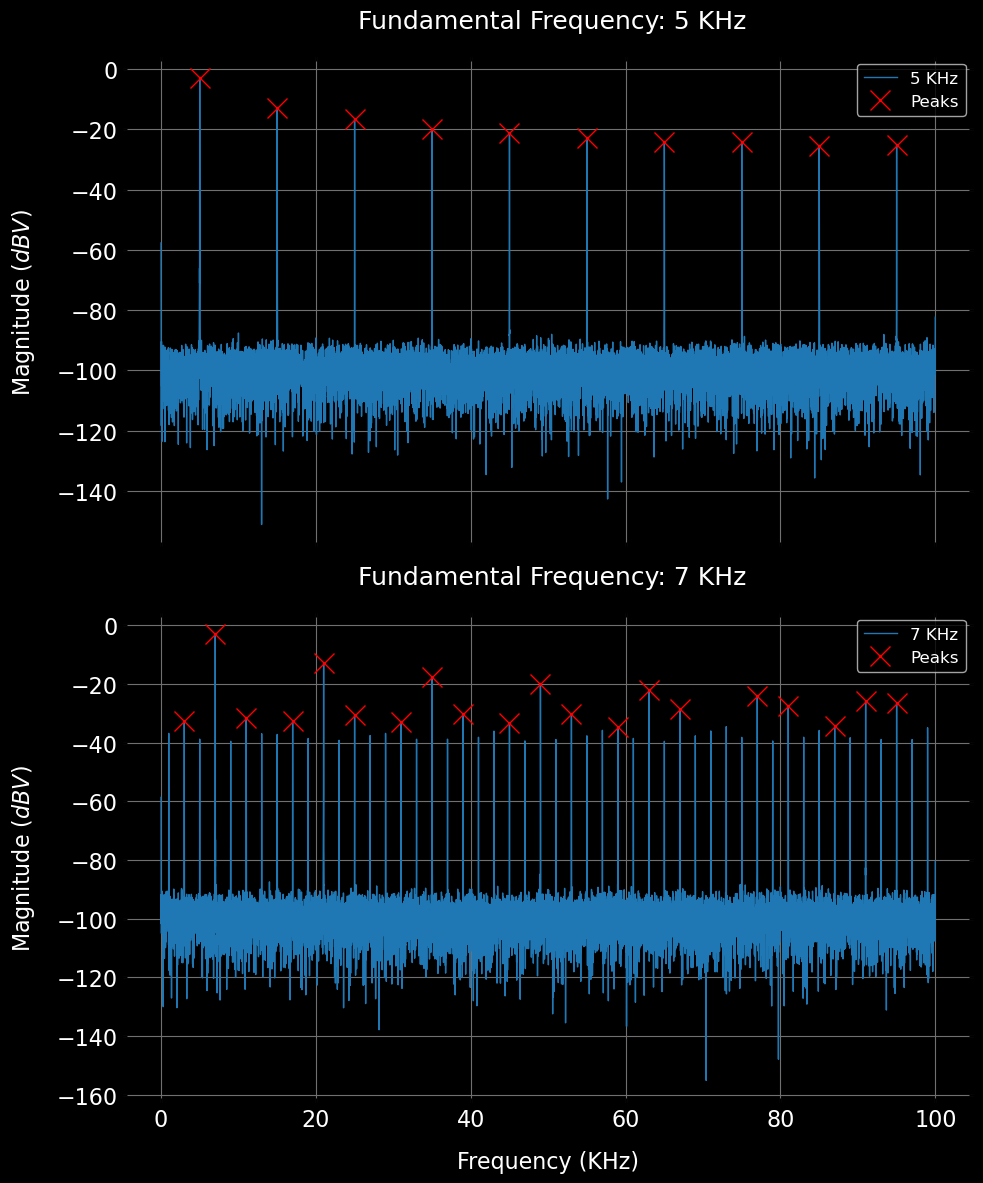

<IPython.core.display.Latex object>

In [7]:
task_dir = data_dir + 'Task2b/csv/'  # Change this to your actual directory

#Initialize Lists
f_l = []  # Frequency in KHz
df_l = []
a_f_l = []
peak_heights_list = []

# Lists to store 5kHz and 7kHz peak heights and frequencies
five_khz_peak_freqs = []
five_khz_peak_heights = []
seven_khz_peak_freqs = []
seven_khz_peak_heights = []

# Process each CSV file in the directory
for path in os.listdir(task_dir):
    if path.endswith('.csv'):
        s = re.findall('.*KHz', path)[0]  # Find the frequency label in the filename
        r = int(s[:-3])  # Extract the numerical value of the frequency
        f_l.append(r)  # Append the frequency to the list (5kHz and 7Khz)

        # Read the CSV file into a dataframe
        df = pd.read_csv(os.path.join(task_dir, path), delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
        df.columns = ['Frequency', 'dbV']
        df_l.append(df)

        # Find peaks in the 'dbV' column
        x = df['Frequency'].values
        y = df['dbV'].values
        peaks, _ = find_peaks(y, height=-60)
        peak_frequencies = x[peaks]
        peak_heights = y[peaks]
        sorted_lists = sorted(zip(peak_heights, peak_frequencies),reverse=True)
        peak_heights, peak_frequencies = zip(*sorted_lists)
        
        # Limit the number of peaks to 10 for 5kHz and 20 for 7kHz
        if r == 5:
            peak_frequencies = peak_frequencies[:10]
            peak_heights = peak_heights[:10]
            five_khz_peak_freqs.extend(peak_frequencies)
            five_khz_peak_heights.extend(peak_heights)
        elif r == 7:
            peak_frequencies = peak_frequencies[:20]
            peak_heights = peak_heights[:20]
            seven_khz_peak_freqs.extend(peak_frequencies)
            seven_khz_peak_heights.extend(peak_heights)

        a_f_l.append(peak_frequencies)
        peak_heights_list.append(peak_heights)

# Plotting Individual Frequency Spectra
fig, axs = plt.subplots(len(df_l), 1, figsize=(10, 6 * len(df_l)), sharex=True)

for i, df in enumerate(df_l):
    axs[i].plot(df['Frequency'], df['dbV'], label=f'{f_l[i]} KHz')
    axs[i].plot(a_f_l[i], peak_heights_list[i], 'x', color='r', label='Peaks')
    axs[i].set_ylabel('Magnitude ($dBV$)')
    axs[i].set_title(f' Fundamental Frequency: {f_l[i]} KHz')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Frequency (KHz)')
plt.tight_layout()
plt.show()
dy(Lx(r'$Figure\, 2.2$: Spectra of the square signal with leading peaks.'))

***Analysis of Frequency Spectra*** 

1. During the experiment, two square signals with fundamental frequencies of 5 kHz and 7 kHz were analyzed using a Picoscope 5000.
<br>

2. Theoretically, a square signal is composed of a sum of sine waves at the fundamental frequency and all its odd harmonics.

- An odd harmonic is a component frequency that is an odd integer multiple of the fundamental frequency.
<br>

3. Hence, it is expected that the frequency spectrum of a 5 kHz signal contains frequencies at (5, 15, 25, 35, 45, ...) kHz, while the spectrum of a 7 kHz signal contains frequencies at (7, 21, 35, ...) kHz.
<br>

4. A sampling rate $f_s = 200 ~kHz$ was used, this means we have a Nyquist freqeuncy $f_c = 100 ~kHz$ . Frequencies above 100 kHz experience aliasing according to the Nyquist-Shannon sampling theorem. 
<br>

5. For the 5 kHz signal, aliasing causes frequencies above 100 kHz to fold back, overlapping with the first 10 peaks.
<br>

6. For the 7 kHz signal, there is less overlap due to the higher fundamental frequency, resulting in more visible peaks in the frequency spectrum.

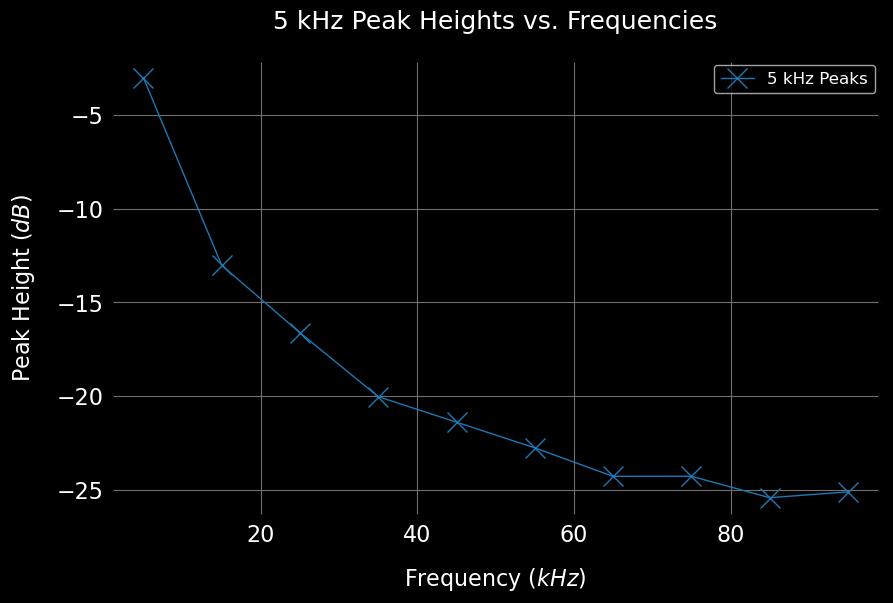

<IPython.core.display.Latex object>

In [8]:
# Plotting 5 kHz peak heights against peak frequencies
sorted_lists = sorted(zip(five_khz_peak_freqs, five_khz_peak_heights))
five_khz_peak_freqs, five_khz_peak_heights = zip(*sorted_lists)
plt.figure(figsize=(10, 6))
plt.plot(five_khz_peak_freqs, five_khz_peak_heights, 'x-', label='5 kHz Peaks')
plt.xlabel('Frequency ($kHz$)')
plt.ylabel('Peak Height ($dB$)')
plt.title('5 kHz Peak Heights vs. Frequencies')
plt.legend()
plt.grid(True)
plt.show()
dy(Lx(r'$Figure\, 2.3$: Peak Heights vs. Frequencies plot of the square wave with $5~kHz$.'))

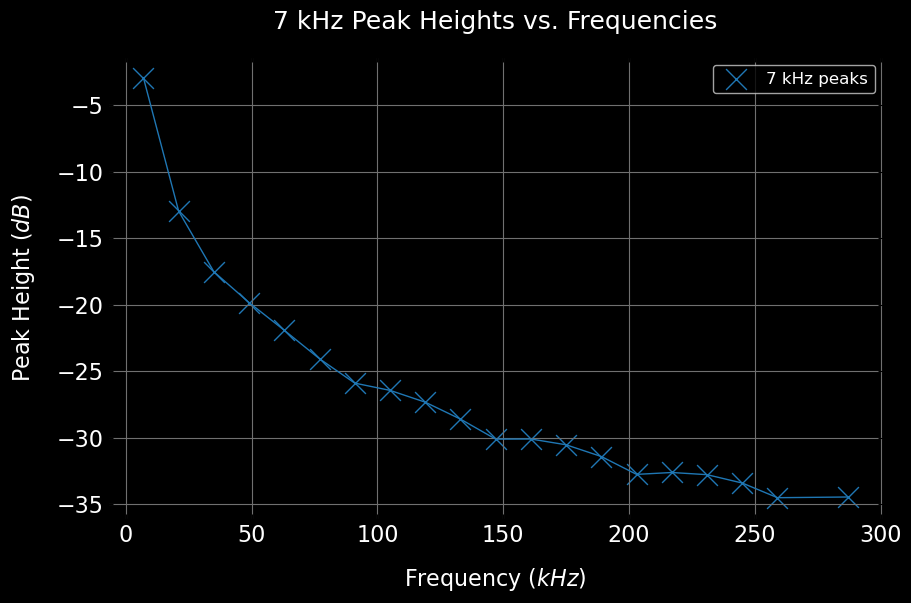

<IPython.core.display.Latex object>

In [9]:
unfolded_freq = np.round(a_f_l[1])
unfolded_peaks = peak_heights_list[1]
for i,(f,a) in enumerate(zip(a_f_l[1], peak_heights_list[1])):
    #print(i,'\tfreq:',f,'\tPeak:',a)
    #print(unfolded_freq[i], unfolded_freq[i]%7, unfolded_freq[i]//7)
    if unfolded_freq[i]//7 % 2 == 1:
        #print('n = 0 \t',np.abs(100*(unfolded_freq[i]%7//2) - unfolded_freq[i]))
        unfolded_freq[i] = np.abs(100*(unfolded_freq[i]%7//2) - unfolded_freq[i])
    elif unfolded_freq[i]//7 % 2 == 0:
        #print('n = 1 \t',np.abs(100*(unfolded_freq[i]%7//2+1) + unfolded_freq[i]))
        unfolded_freq[i] = np.abs(100*(unfolded_freq[i]%7//2+1) + unfolded_freq[i])
    else:
        print('error')

sorted_lists = sorted(zip(unfolded_freq, unfolded_peaks),reverse=True)
unfolded_freq, unfolded_peaks = zip(*sorted_lists)
#unfolded_freq.sort()
#print(a_f_l[1])
#print(fit)
#print(np.sqrt(fit[1][0][0]))
plt.plot(unfolded_freq, unfolded_peaks)
plt.scatter(unfolded_freq,unfolded_peaks, label='7 kHz peaks', marker='x')
plt.xlabel('Frequency ($kHz$)')
plt.ylabel('Peak Height ($dB$)')
plt.title('7 kHz Peak Heights vs. Frequencies')
plt.legend()
plt.grid(True)
plt.show()
dy(Lx(r'$Figure\, 2.4$: Peak Heights vs. Frequencies plot of the square wave with reconstructed original frequencies.'))

***Analysis of Peak Height Graphs*** 

1. Theoretically, the amplitude of the n-th harmonic is given by: $$\frac{A_F}{n} \label{eq2.1} \tag{2.1}$$

- $n$: Odd Interger
- $A_f$: Amplitude or Peak Height of Fundamental Freqeuncy

2. Therefore, it is expected that the peak heights will decay like $\frac{1}{f}$ as $f$ increases. 

3. From the peak height vs. frequency graphs, it is observed that both graphs exhibit the expected $\frac{1}{f}$ decay.

## Task 3

### Task 3a

***Task Definition*** 

Measure the spectra of a square signal using a rectangular, a Hann and a flat-top window along with the following parameters. 

Use the following parameters: Time constant of 1 ms, 20 kS, 16384 points in the spectrum and a frequency of 1 kHz 

Compare the spectra. What do you observe? 

Explain which windowing method has the worst amplitude resolution, and which has the worst frequency resolution.

***Measurements***

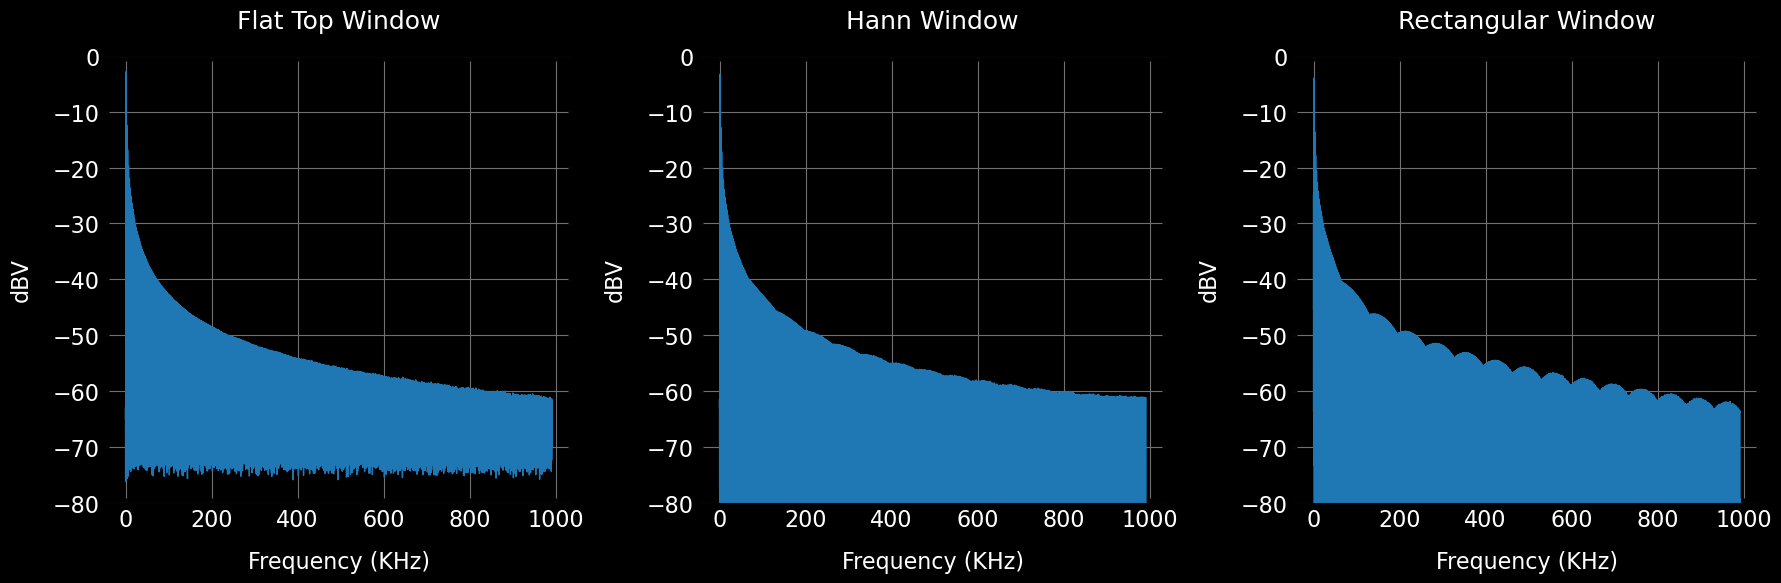

<IPython.core.display.Latex object>

In [10]:
task_dir = data_dir + 'Task3a/csv/'

# Read the CSV files and rename columns
df_rect = pd.read_csv(task_dir + 'Flat Top Window.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_rect.columns = ['Frequency', 'Voltage'] 
df_ft = pd.read_csv(task_dir + 'Hann Window.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_ft.columns = ['Frequency', 'Voltage']
df_triang = pd.read_csv(task_dir + 'Rectangular Window.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_triang.columns = ['Frequency', 'Voltage']

# Plot each DataFrame in a separate graph side by side with grids
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Flat Top Window data
axs[0].plot(df_rect['Frequency'][:35000], df_rect['Voltage'][:35000])
axs[0].set_title('Flat Top Window')
axs[0].set_xlabel('Frequency (KHz)')
axs[0].set_ylabel('dBV')
axs[0].set_ylim(-80, 0)  # Set y-axis limits
axs[0].grid(True)

# Plot Hann Window data
axs[1].plot(df_ft['Frequency'][:35000], df_ft['Voltage'][:35000])
axs[1].set_title('Hann Window')
axs[1].set_xlabel('Frequency (KHz)')
axs[1].set_ylabel('dBV')
axs[1].set_ylim(-80, 0)  # Set y-axis limits
axs[1].grid(True)

# Plot Rectangular Window data
axs[2].plot(df_triang['Frequency'][:350000], df_triang['Voltage'][:35000])
axs[2].set_title('Rectangular Window')
axs[2].set_xlabel('Frequency (KHz)')
axs[2].set_ylabel('dBV')
axs[2].set_ylim(-80, 0)  # Set y-axis limits
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
dy(Lx(r'$Figure\, 3.1$: Comparison of the amplitude of the square wave with different windowing.'))

***Amplitude Resolution Analysis*** 

1. It is observed that the rectangular window has the worst amplitude resolution while the Flat Top window has the best amplitude resolution.
<br>

2. This is because the side lobes are most visible using the Rectangular window, and gets progressively less visible towards the left.
<br>

3. Theoretically, the presence of side lobes indicates leakage of signal energy from the main lobe to the adjacent frequency bins. The leakage causes the amplitude of the main lobe to decrease, and leads to ampltude distortion and inaccuracies in signal ampltude estimation.
<br>

4. Therefore, more visible side lobes indicates a lower ampltiude resolution because they make it difficult to accurately measure signal amplitudes.

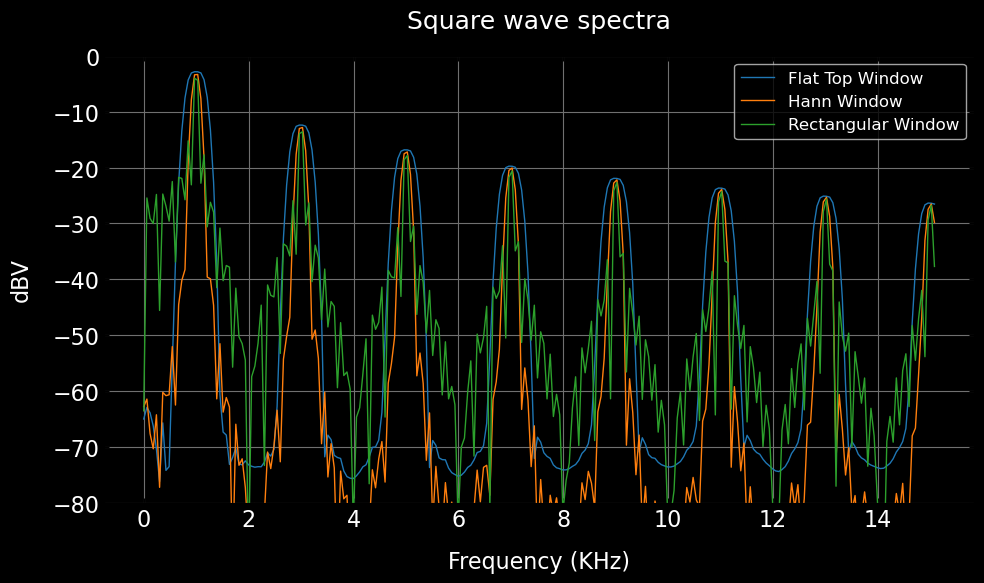

<IPython.core.display.Latex object>

In [11]:
# Define the directory path
task_dir = data_dir + 'Task3a/csv/'

# Read the CSV files and rename columns
df_rect = pd.read_csv(task_dir + 'Flat Top Window.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_rect.columns = ['Frequency', 'Voltage'] 
df_ft = pd.read_csv(task_dir + 'Hann Window.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_ft.columns = ['Frequency', 'Voltage']
df_triang = pd.read_csv(task_dir + 'Rectangular Window.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_triang.columns = ['Frequency', 'Voltage']

# Plot each DataFrame in a separate graph side by side with grids
fig, axs = plt.subplots(1, 1)

# Plot Flat Top Window data
axs.plot(df_rect['Frequency'][:250], df_rect['Voltage'][:250], label = 'Flat Top Window')
axs.set_xlabel('Frequency (KHz)')
axs.set_ylabel('dBV')



# Plot Hann Window data
axs.plot(df_ft['Frequency'][:250], df_ft['Voltage'][:250], label = 'Hann Window')
axs.set_xlabel('Frequency (KHz)')
axs.set_ylabel('dBV')

# Plot Rectangular Window data
axs.plot(df_triang['Frequency'][:250], df_triang['Voltage'][:250], label = 'Rectangular Window')
axs.set_xlabel('Frequency (KHz)')
axs.set_ylabel('dBV')
axs.set_ylim(-80, 0)  # Set y-axis limits
axs.grid(True)

# Adjust layout to prevent overlap
plt.title('Square wave spectra')
plt.legend()
plt.tight_layout()
plt.show()
dy(Lx(r'$Figure\, 3.2$: Comparison of the frequency resolution of the square wave with different windowing.'))

***Frequency Resolution Analysis*** 

1. It is observed that the Flat-Top window has the worst frequency resolution, whereas the rectangular window has the best frequency resolution.
<br>

2. This is because the Flat-Top window generates the most broad peaks whilst the Rectangular window generates the narrowest peaks.
<br>

3. In theory,an ideal Fourier Transform would yield sharp signal peaks resembling Dirac Delta Distributions. However, achieving this requires sampling the signal for an infinitely long duration of time, which is impractical. 
<br>

4. Consequently, windowing functions which yield sharp peaks resembling Dirac Delta Distributions offer a greater frequency resolution, while those with broader peaks offer a poorer freqeuncy resolution.

### Task3b

***Task Definition*** 

Measure the spectra of a sine signal using a rectangular, a triangular and a flat-top window. Use parameters such that you can see a distinct Fraunhofer pattern in case of the rectangular window. Compare the theoretical expressions for rectangular and triangular windowing quantitatively to the data.

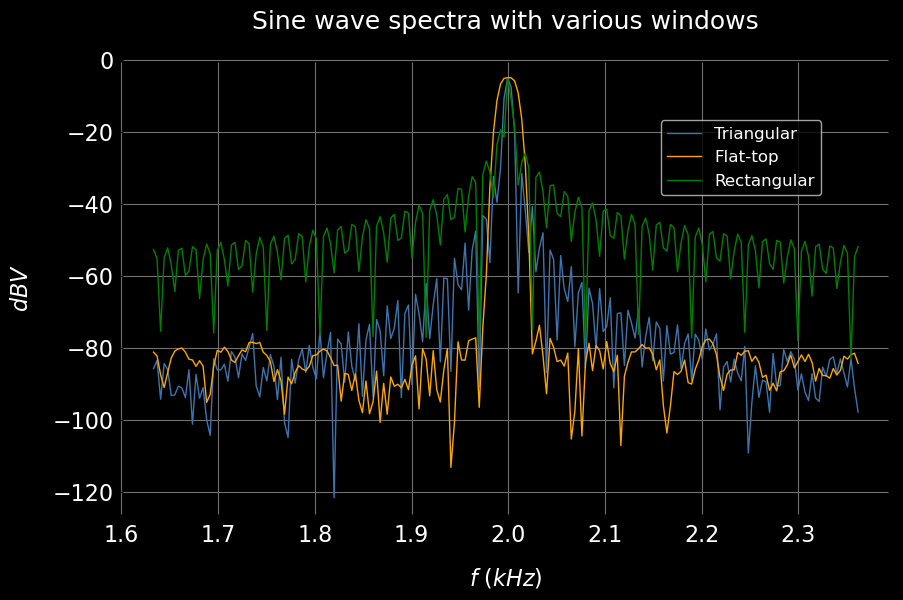

<IPython.core.display.Latex object>

In [12]:
# Data Preprocessing
task_dir = data_dir + 'Task3b/csv/'
df_rect = pd.read_csv(task_dir + 'Rect.csv', delimiter=';', skiprows=1, dtype=np.float64, decimal=',')
df_rect.columns = ['Frequency', 'Voltage'] 
df_ft = pd.read_csv(task_dir + 'Flat_top.csv', delimiter=';', skiprows=1, dtype=np.float64, decimal=',')
df_ft.columns = ['Frequency', 'Voltage']
df_triang = pd.read_csv(task_dir + 'Triangular.csv', delimiter=';', skiprows=1, dtype=np.float64, decimal=',')
df_triang.columns = ['Frequency', 'Voltage']
freq = np.array(df_rect['Frequency'])
A_rect = np.array(df_rect['Voltage'])
A_ft = np.array(df_ft['Voltage'])
A_triang = np.array(df_triang['Voltage'])
rect_max_ind = A_rect.argmax()
triang_max_ind = A_triang.argmax()
ft_max_ind = A_ft.argmax()
plt.plot(freq[triang_max_ind-100:triang_max_ind+100], A_triang[triang_max_ind-100:triang_max_ind+100], color='#3b75af', label='Triangular')
#plt.scatter(freq[triang_max_ind], A_triang[triang_max_ind], marker='x')
plt.plot(freq[ft_max_ind-100:ft_max_ind+100], A_ft[ft_max_ind-100:ft_max_ind+100], color='orange', label='Flat-top')
#plt.scatter(freq[ft_max_ind], A_ft[ft_max_ind], marker='x')
plt.plot(freq[rect_max_ind-100:rect_max_ind+100], A_rect[rect_max_ind-100:rect_max_ind+100],color='green', label='Rectangular')
#plt.scatter(freq[rect_max_ind], A_rect[rect_max_ind], marker='x')
plt.title(r'Sine wave spectra with various windows')
plt.xlabel(r'$f$ ($kHz$)')
plt.ylabel(r'$dBV$')
plt.legend(loc=(0.7,0.7))
plt.grid(True)
plt.show()
dy(Lx(r'$Figure\, 3.4$: Spectra of sine wave with different windowing.'))

***Analysis***

For effective comparison of different window functions, several key properties are considered. One of them is the main lobe width, which describes the shape of the central response peak. 

The main lobe width is defined as the extent (in FFT bins or frequency lines) where the window response falls to a specific level relative to the peak gain. The -6 dB main lobe width is analysed, which corresponds to a window response of half the peak value (0.5). $^{[4]}$

In [13]:
def dbv_to_linear(y_dBV):
    return 10**(y_dBV / 20)

def identify_main_lobe_width(x, y_dBV):
    y_linear = dbv_to_linear(y_dBV)
    main_peak_idx = np.argmax(y_linear)
    main_peak_value = y_linear[main_peak_idx]
    main_peak_frequency = x[main_peak_idx]
    
    half_max = main_peak_value / np.sqrt(2)
    
    left_idx = np.where(y_linear[:main_peak_idx] < half_max)[0]
    right_idx = np.where(y_linear[main_peak_idx:] < half_max)[0] + main_peak_idx
    
    if left_idx.size > 0:
        left_six_dB_point = x[left_idx[-1]]
    else:
        left_six_dB_point = x[0]
    
    if right_idx.size > 0:
        right_six_dB_point = x[right_idx[0]]
    else:
        right_six_dB_point = x[-1]
    main_lobe_width = right_six_dB_point - left_six_dB_point
    return main_lobe_width, main_peak_frequency

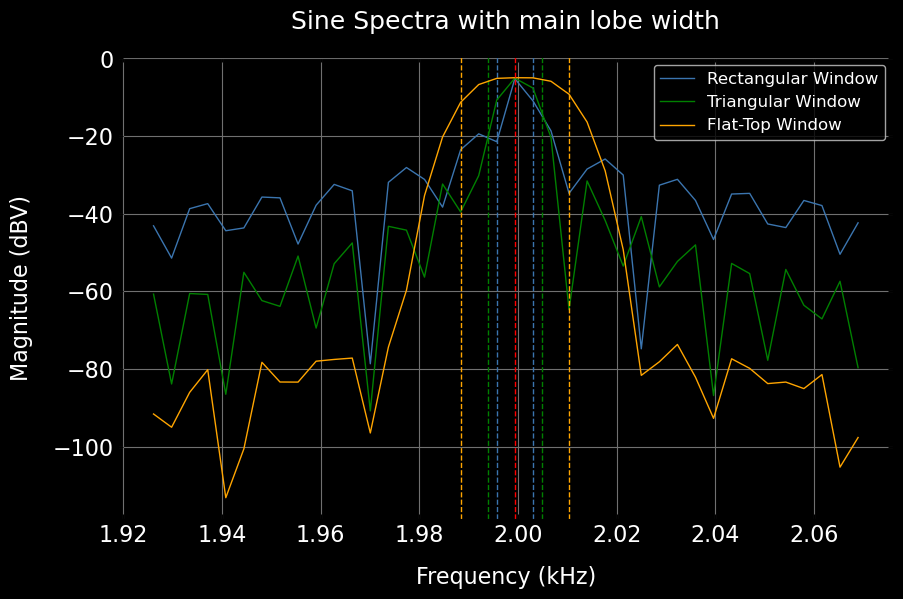

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [14]:
main_lobe_width_rectangular, main_peak_rectangular = identify_main_lobe_width(freq, A_rect)
main_lobe_width_triangular, main_peak_triangular = identify_main_lobe_width(freq, A_triang)
main_lobe_width_flattop, main_peak_flattop = identify_main_lobe_width(freq, A_ft)

# Plot spectra with main lobe width annotation
plt.plot(freq[rect_max_ind-20:rect_max_ind+20], A_rect[rect_max_ind-20:rect_max_ind+20], color='#3b75af', label="Rectangular Window")
plt.axvline(x=main_peak_rectangular - main_lobe_width_rectangular / 2, color='#3b75af', linestyle='--')
plt.axvline(x=main_peak_rectangular + main_lobe_width_rectangular / 2, color='#3b75af', linestyle='--')

plt.plot(freq[triang_max_ind-20:triang_max_ind+20], A_triang[triang_max_ind-20:triang_max_ind+20], color='g', label="Triangular Window")
plt.axvline(x=main_peak_triangular - main_lobe_width_triangular / 2, color='g', linestyle='--')
plt.axvline(x=main_peak_triangular + main_lobe_width_triangular / 2, color='g', linestyle='--')

plt.plot(freq[ft_max_ind-20:ft_max_ind+20], A_ft[ft_max_ind-20:ft_max_ind+20],color='orange', label="Flat-Top Window")
plt.axvline(x=main_peak_flattop, color='r', linestyle='--')
plt.axvline(x=main_peak_flattop - main_lobe_width_flattop / 2, color='orange', linestyle='--')
plt.axvline(x=main_peak_flattop + main_lobe_width_flattop / 2, color='orange', linestyle='--')
plt.title("Sine Spectra with main lobe width")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude (dBV)")
plt.legend()
plt.grid()
plt.show()
dy(Lx(r'$Figure\, 3.5$: Frequency resolution comparison.'))
# Print results
dy(Lx(r"$$\Delta f_{Rectangular} = %.2f Hz$$" % (main_lobe_width_rectangular*1e3)))
dy(Lx(r"$$\Delta f_{Triangular} = %.2f Hz$$" % (main_lobe_width_triangular*1e3)))
dy(Lx(r"$$\Delta f_{Flat-Top} = %.2f Hz$$" % (main_lobe_width_flattop*1e3)))

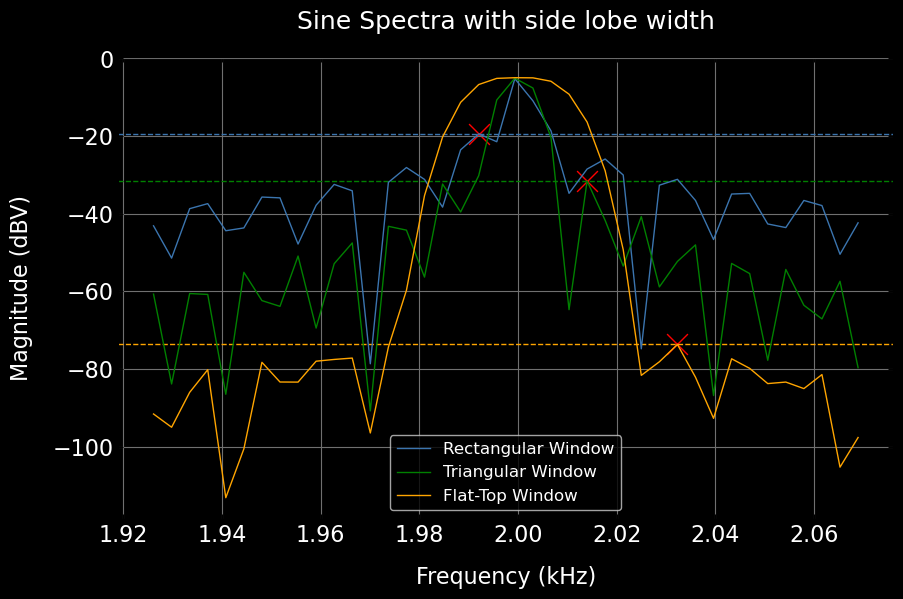

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [15]:
peaks_rect, _ = find_peaks(A_rect[rect_max_ind-20:rect_max_ind+20], height=-40)
peaks_triang, _ = find_peaks(A_triang[triang_max_ind-20:triang_max_ind+20], height=-60)
peaks_ft, _ = find_peaks(A_ft[ft_max_ind-20:ft_max_ind+20], height=-80)
peaks_rect = peaks_rect + rect_max_ind-20
peaks_triang = peaks_triang + triang_max_ind-20
peaks_ft = peaks_ft + ft_max_ind-20

A_rect_cut = A_rect[peaks_rect]
freq_cut = freq[peaks_rect] 
A_rect_cut[A_rect_cut.argmax()] = -np.inf
freq_side_lobe_rect = freq_cut[A_rect_cut.argmax()]
first_side_lobe_rect = A_rect_cut[A_rect_cut.argmax()]

A_triang_cut = A_triang[peaks_triang]
freq_cut = freq[peaks_triang] 
A_triang_cut[A_triang_cut.argmax()] = -np.inf
freq_side_lobe_triang = freq_cut[A_triang_cut.argmax()]
first_side_lobe_triang = A_triang_cut[A_triang_cut.argmax()]

A_ft_cut = A_ft[peaks_ft]
freq_cut = freq[peaks_ft] 
A_ft_cut[A_ft_cut.argmax()] = -np.inf
freq_side_lobe_ft = freq_cut[A_ft_cut.argmax()]
first_side_lobe_ft = A_ft_cut[A_ft_cut.argmax()]

plt.axhline(first_side_lobe_rect, color='#3b75af', linestyle='--')
plt.axhline(first_side_lobe_triang, color='g', linestyle='--')
plt.axhline(first_side_lobe_ft, color='orange', linestyle='--')
plt.scatter(freq_side_lobe_rect, first_side_lobe_rect, color='red', marker = 'x')
plt.scatter(freq_side_lobe_triang, first_side_lobe_triang, color = 'red', marker = 'x')
plt.scatter(freq_side_lobe_ft, first_side_lobe_ft, color = 'red', marker = 'x')
plt.plot(freq[rect_max_ind-20:rect_max_ind+20], A_rect[rect_max_ind-20:rect_max_ind+20], color='#3b75af', label="Rectangular Window")
plt.plot(freq[triang_max_ind-20:triang_max_ind+20], A_triang[triang_max_ind-20:triang_max_ind+20], color='g', label="Triangular Window")
plt.plot(freq[ft_max_ind-20:ft_max_ind+20], A_ft[ft_max_ind-20:ft_max_ind+20],color='orange', label="Flat-Top Window")
plt.title("Sine Spectra with side lobe width")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude (dBV)")
plt.legend()
plt.grid()
plt.show()
dy(Lx(r'$Figure\, 3.6$: Amplitude resolution comparison.'))
dy(Lx(r"$$L_{Rectangular} = %.2f ~dBV$$" % (first_side_lobe_rect)))
dy(Lx(r"$$L_{Triangular} = %.2f ~dBV$$" % (first_side_lobe_triang)))
dy(Lx(r"$$L_{Flat-Top} = %.2f ~dBV$$" % (first_side_lobe_ft)))

In conclusion,

- Rectangular Window: The narrowest main lobe but higher side lobes, indicating good frequency resolution but poorer amplitude resolution.
- Triangular Window: Wider main lobe than the rectangular window, with lower side lobes, providing a balance between frequency and amplitude resolution.
- Flat-Top Window: Widest main lobe with the lowest side lobes(accurate amplitude) but poorer frequency resolution.

## Task 4

***Task Definition*** 

Create a WAV file from an arbitrary function. Feed this sound into the oscilloscope and do a spectral analysis. 

***Procedure*** 

1. During this task, a sound (WAV) file was generated the using the sinusodial function:  

$$ f(t) = \cos\left(2\pi \cdot 220 \cdot t\right) + \sin\left(2\pi \cdot 440 \cdot t\right) $$

- $t$ : Time steps generated based on a sampling rate

2. The audio output of the sound file was analyzed using a Picoscope 5000.


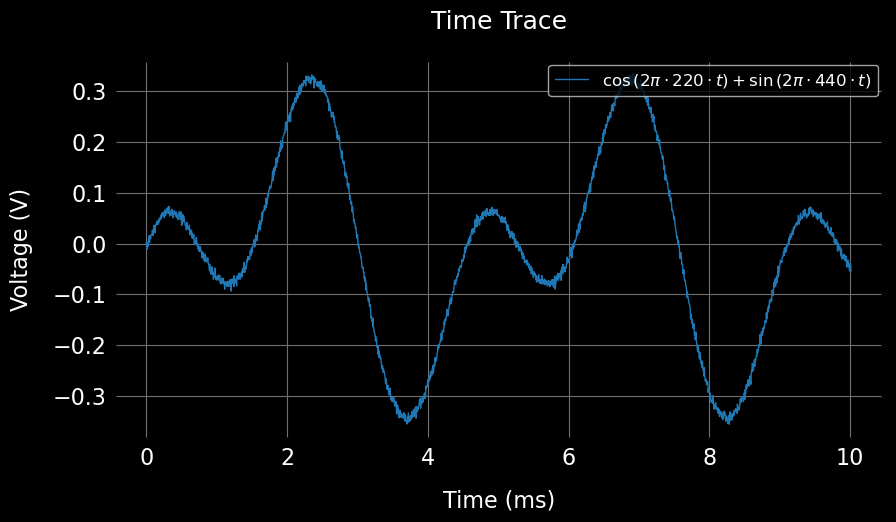

<IPython.core.display.Latex object>

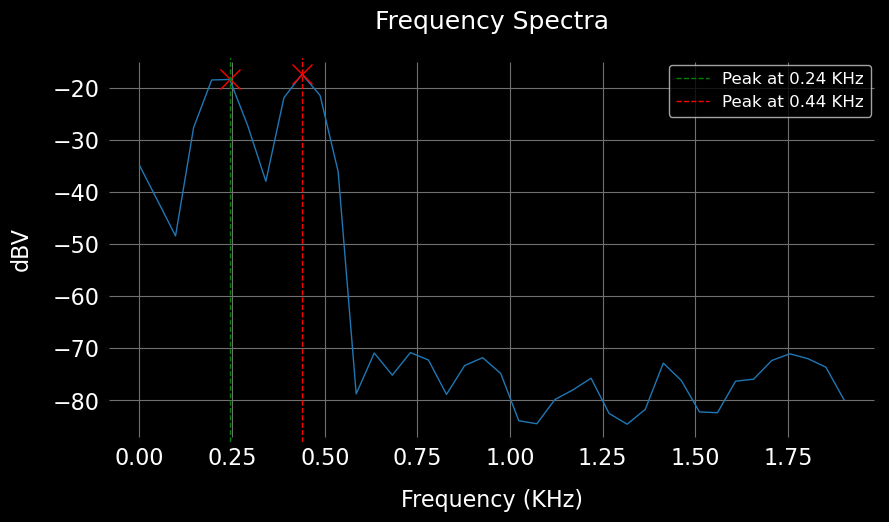

<IPython.core.display.Latex object>

In [16]:
task_dir = data_dir + 'Task4/csv/'

df_time = pd.read_csv(task_dir + 'Trace.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_time.columns = ['Time', 'Voltage'] 
df_spectra = pd.read_csv(task_dir + 'Freq.csv', delimiter=',', skiprows=1, dtype=np.float64, decimal='.')
df_spectra.columns = ['Frequency', 'Voltage']
df_spectra = df_spectra.head(40)

plt.figure(figsize=(10, 5))
plt.plot(df_time['Time'], df_time['Voltage'], label=r'$\cos\left(2\pi \cdot 220 \cdot t\right) + \sin\left(2\pi \cdot 440 \cdot t\right)$')
plt.title('Time Spectra')
plt.title('Time Trace')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
dy(Lx(r'$Figure\, 4.1$: Time trace of the sound wave.'))

plt.figure(figsize=(10, 5))
plt.plot(df_spectra['Frequency'], df_spectra['Voltage'], label='_nolegend_')
peaks, _ = find_peaks(df_spectra['Voltage'], height=-40)
peak_freqs = df_spectra['Frequency'][peaks]
plt.plot(peak_freqs, df_spectra['Voltage'][peaks], 'rx', label='_nolegend_')

colors = ['g', 'r']
for i, peak in enumerate(peaks):
    plt.axvline(x=df_spectra['Frequency'][peak], color=colors[i % len(colors)], linestyle='--')

legend_labels = []
for freq in peak_freqs:
    legend_labels.append(f'Peak at {freq:.2f} KHz')
plt.legend(legend_labels)

plt.title('Frequency Spectra')
plt.xlabel('Frequency (KHz)')
plt.ylabel('dBV')
plt.grid(True)
plt.show()
dy(Lx(r'$Figure\, 4.2$: Frequency Spectra of the sound wave.'))

***Analysis*** 

1. Theoretically, the generated signal is a beat with frequencies $0.22 ~kHz$  and $0.44 ~kHz$  respectively.These frequencies correspond to the peaks in the signal's frequency spectra.
<br>

2. Upon inspection of the frequency spectra, it is observed that the peaks closely correspond to the theoretical freqeuncies as expected.

## References

1) [E19e Lab instruction](https://moodle2.uni-leipzig.de/pluginfile.php/3621567/mod_resource/content/2/E19e_2024.pdf)
2) [Nyquist Theorem](https://www.translatorscafe.com/unit-converter/en-US/calculator/aliasing-frequency/?f=39&fu=kHz&fs=44.1&fsu=kHz)
3) [Picoscope Datasheet](https://www.picotech.com/download/datasheets/picoscope-5000d-series-data-sheet.pdf)
4) [Michael Cerna and Audrey F. Harvey, "The Fundamentals of FFT-Based Signal Analysis and Measurement", National Instrument, Application Note 041](https://www.sjsu.edu/people/burford.furman/docs/me120/FFT_tutorial_NI.pdf)